# Analyse von Hunderassen und ihren Gesundheitsproblemen

Dieses Notebook analysiert Daten über Hunderassen, um zu verstehen, welches Hauptmerkmal am stärksten mit häufigen Gesundheitsproblemen korreliert.

In [123]:
# Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import re
import sqlite3
from kaggle.api.kaggle_api_extended import KaggleApi

In [124]:
# Kaggle-API-Konfiguration und Datenladen
api = KaggleApi()
api.authenticate()
api.dataset_download_files("marshuu/dog-breeds", unzip=True, path='../data')
df_csv = pd.read_csv('../data/dog_breeds.csv')

In [125]:
# Funktion zur Berechnung des Durchschnitts aus einem Bereich
def calculate_average_range(value):
    numbers = re.findall(r'\d+\.?\d*', value)
    if len(numbers) == 2:
        average = (float(numbers[0]) + float(numbers[1])) / 2
        return average
    elif len(numbers) == 1:
        return float(numbers[0])
    else:
        return None

# Berechnen des Durchschnitts der Höhe in Zoll und der Lebensdauer
df_csv['height_in'] = df_csv['Height (in)'].apply(calculate_average_range)
df_csv['longevity_yrs'] = df_csv['Longevity (yrs)'].apply(calculate_average_range)

# Umwandeln der Höhe von Zoll zu Zentimeter
df_csv['height_cm'] = df_csv['height_in'] * 2.54

# Entfernen der ursprünglichen Bereichsspalten, einschließlich height_in
df_csv.drop(['Height (in)', 'Longevity (yrs)', 'height_in'], axis=1, inplace=True)

In [126]:
# Speichern der CSV-Daten in eine SQLite-Datenbank
conn = sqlite3.connect('../data/dog_breeds.db')
df_csv.to_sql('original_data', conn, if_exists='replace', index=False)

# Laden der Daten aus der Datenbank und Bereinigung der Spaltennamen und Daten
df = pd.read_sql_query('SELECT * FROM original_data', conn)

# Spaltennamen normalisieren: Kleinbuchstaben, Leerzeichen durch Unterstriche ersetzen und Klammern entfernen
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace(r'[()]', '', regex=True)

# Liste der Spalten die in Kleinbuchstaben umgewandelt werden soll
string_columns = ['breed', 'country_of_origin', 'fur_color', 'color_of_eyes', 'character_traits', 'common_health_problems']

# Konvertieren der Zeichenfolgenspalten in Kleinbuchstaben
for col in string_columns:
    if col in df.columns:
        df[col] = df[col].str.lower()

# Entfernen Sie doppelte Spaltennamen, wenn nötig
df = df.loc[:, ~df.columns.duplicated()]

# Bereinigte Daten in die Datenbank schreiben
df.to_sql('cleaned_data', conn, if_exists='replace', index=False)

117

In [127]:
# Gruppeneinteilung basierend auf der Größe
median_height = df['height_cm'].median()
df['size_group'] = np.where(df['height_cm'] > median_height, 'large', 'small')

# Umwandlung der Zeichenfolgenspalten in Dummy-Variablen für die Charaktereigenschaften und Gesundheitsprobleme
character_traits_dummies = df['character_traits'].str.get_dummies(sep=', ')
health_problems_dummies = df['common_health_problems'].str.get_dummies(sep=', ')

# Kombination der Dummy-Variablen mit dem ursprünglichen DataFrame
df = pd.concat([df, character_traits_dummies, health_problems_dummies], axis=1)

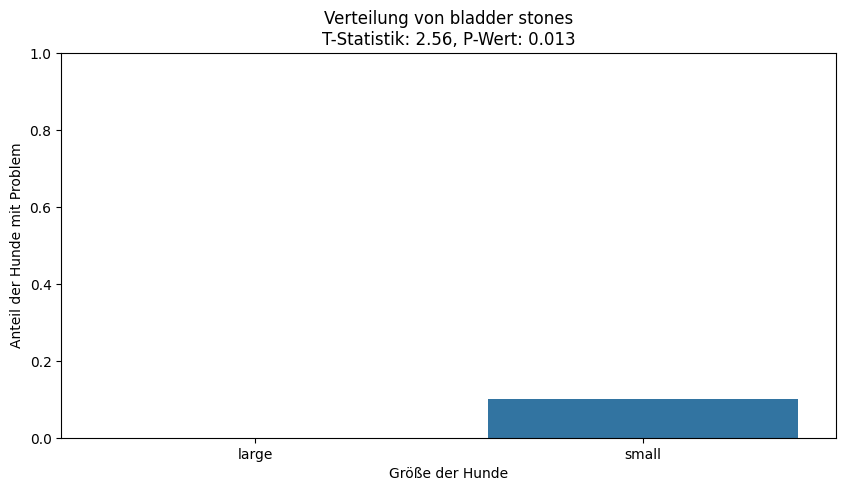

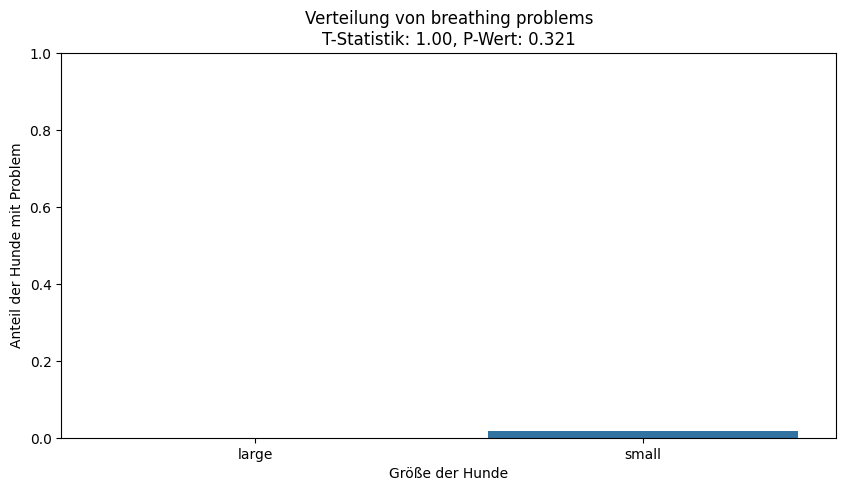

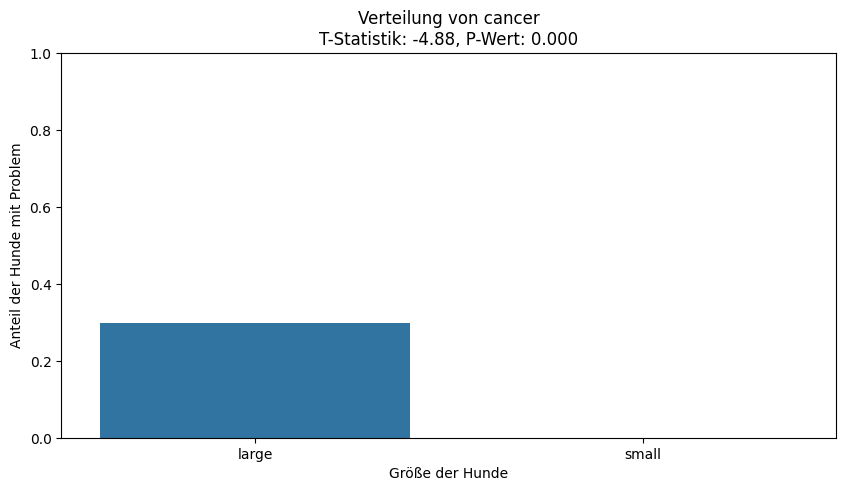

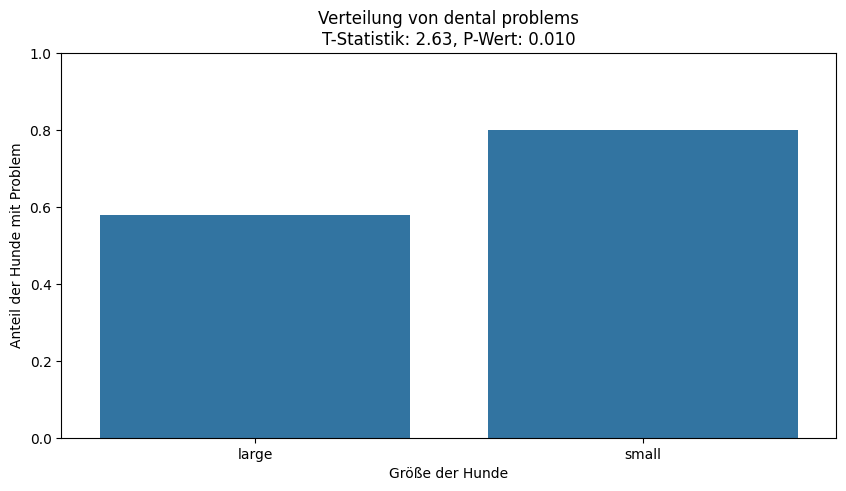

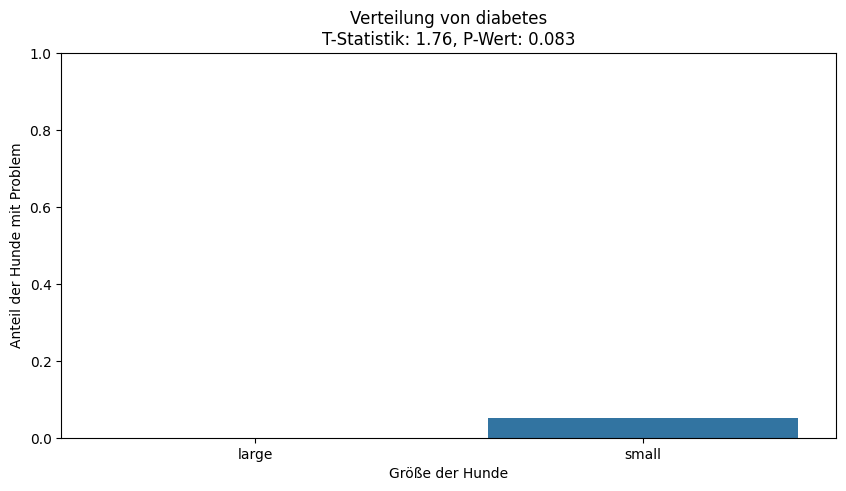

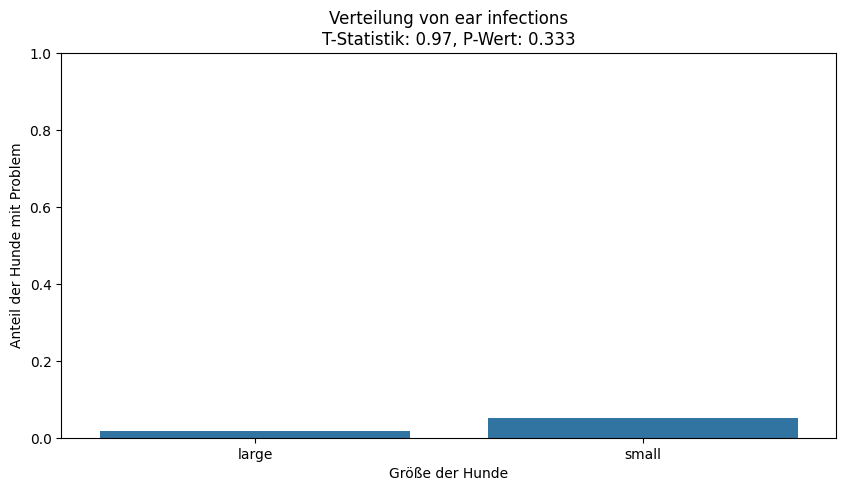

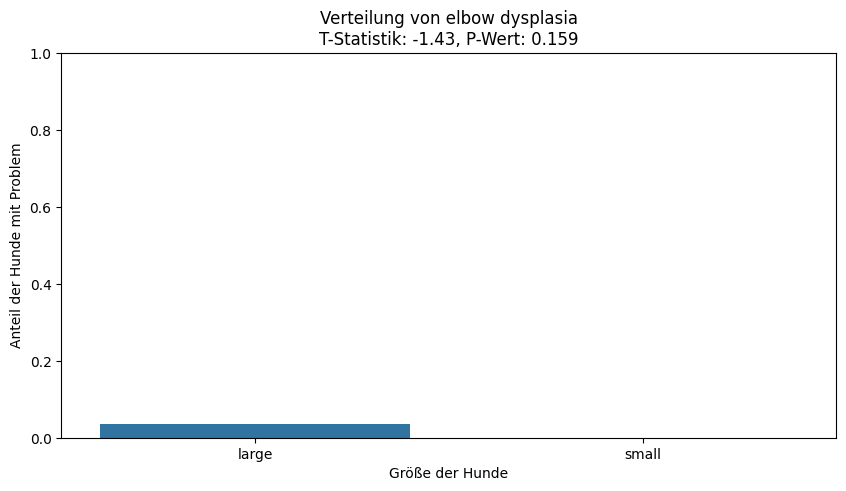

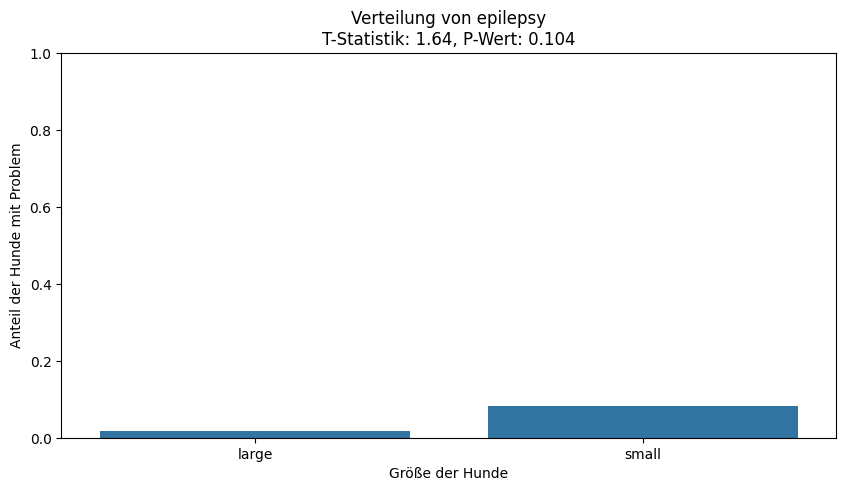

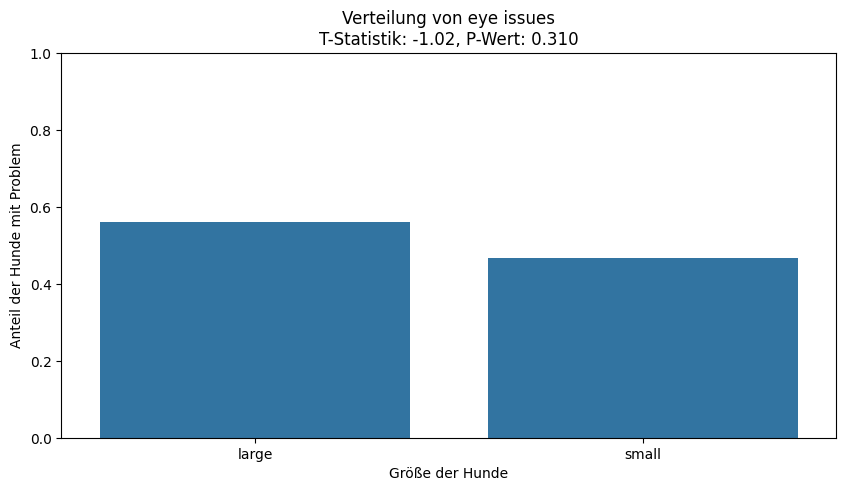

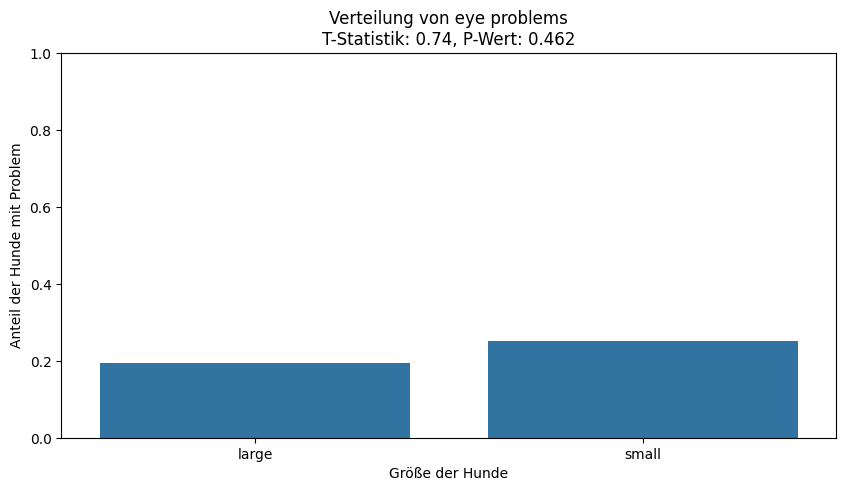

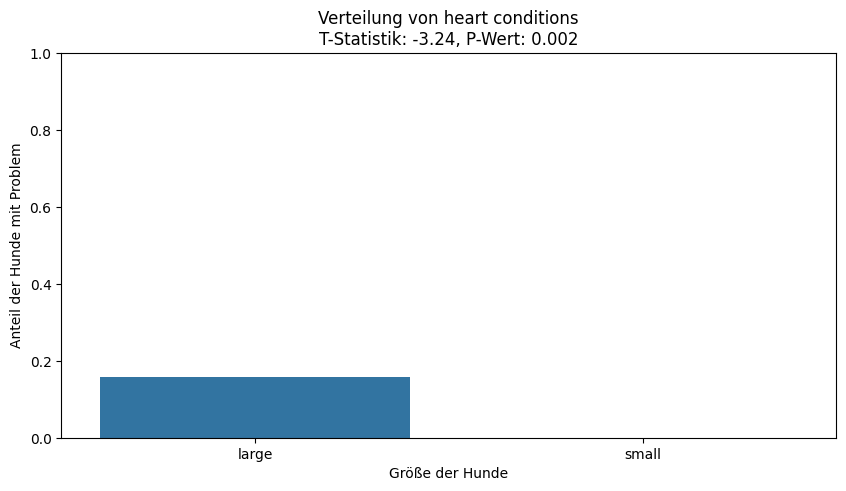

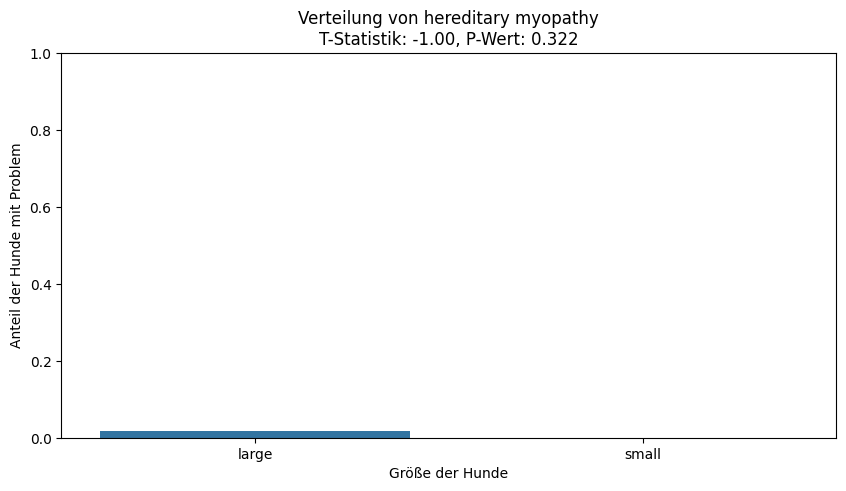

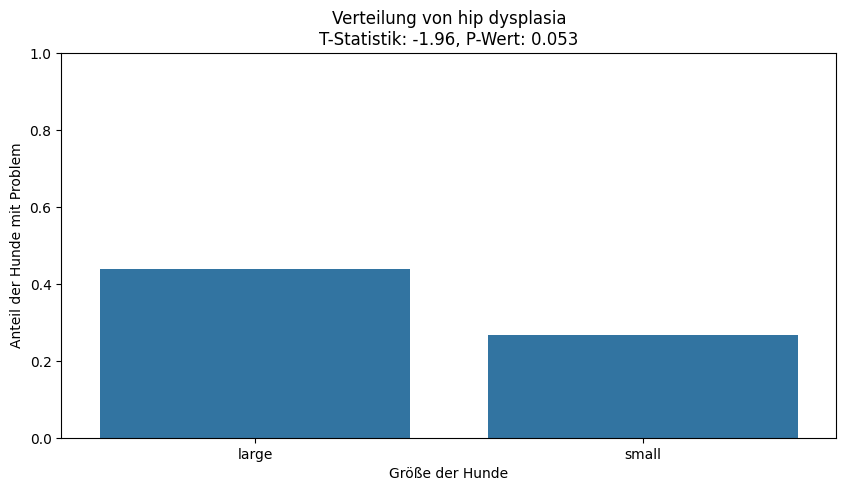

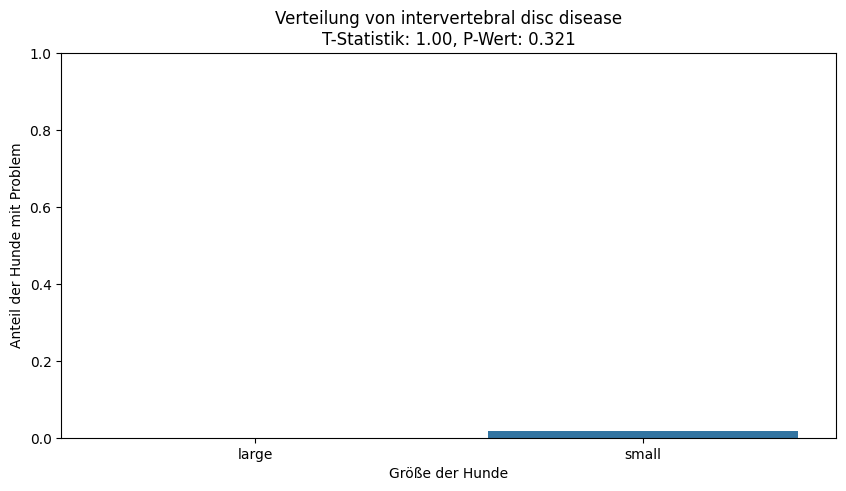

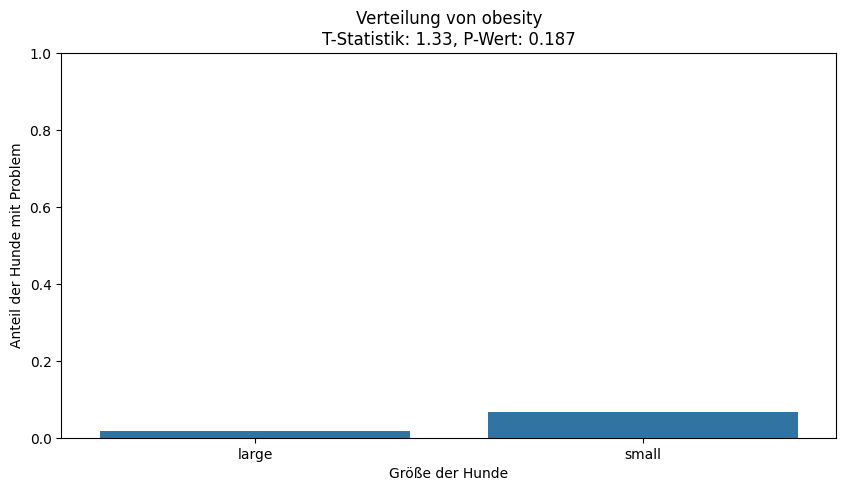

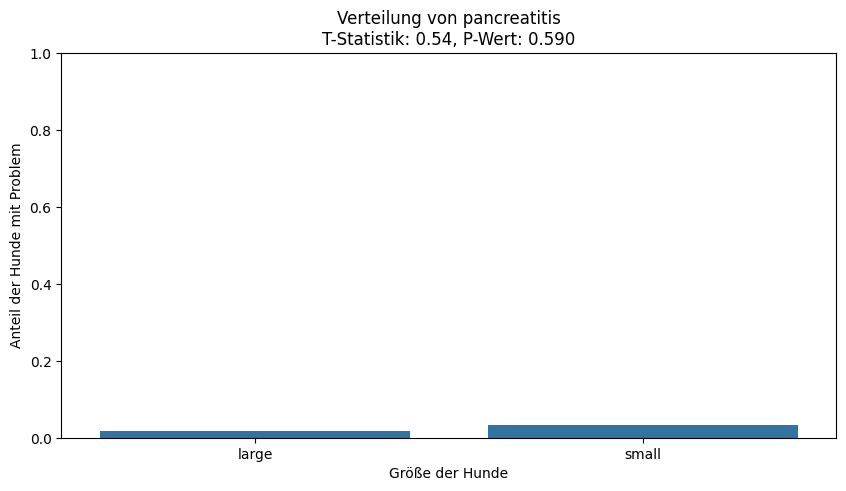

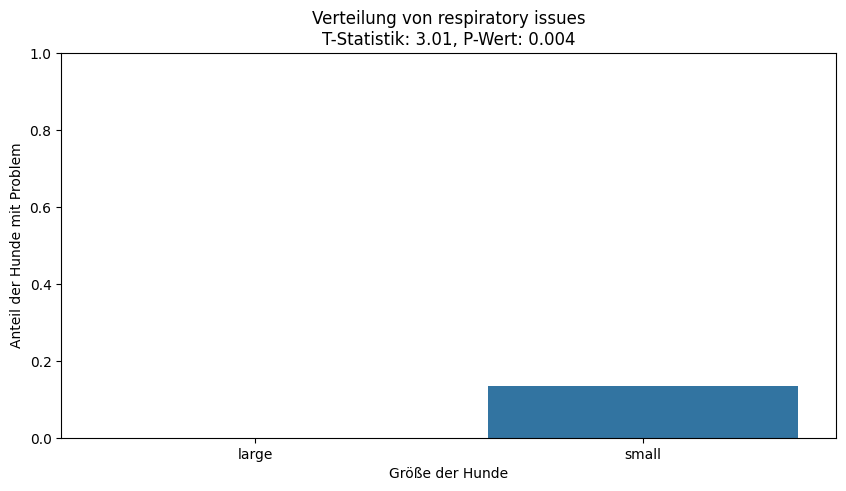

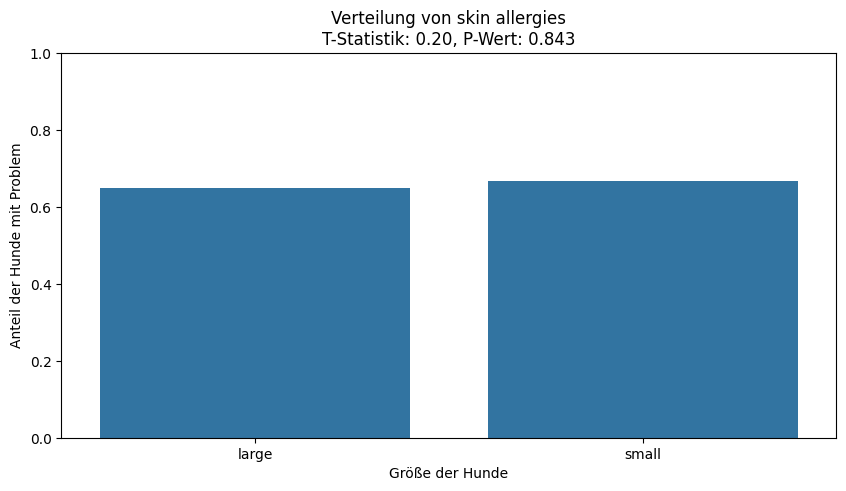

In [128]:
# Durchführung von T-Tests zwischen großen und kleinen Hunden
health_issues_columns = [col for col in health_problems_dummies.columns]

results = []
for issue in health_issues_columns:
    small_dogs = df[df['size_group'] == 'small'][issue]
    large_dogs = df[df['size_group'] == 'large'][issue]

    # Durchführen eines T-Tests
    t_stat, p_value = ttest_ind(small_dogs, large_dogs, equal_var=False)

    # Visualisierung der Ergebnisse
    plt.figure(figsize=(10, 5))
    sns.barplot(x='size_group', y=issue, data=df, estimator=np.mean, errorbar=None)
    plt.title(f'Verteilung von {issue}\nT-Statistik: {t_stat:.2f}, P-Wert: {p_value:.3f}')
    plt.ylabel('Anteil der Hunde mit Problem')
    plt.xlabel('Größe der Hunde')
    plt.ylim(0, 1)

    # Diagramm speichern
    chart_path = f"../static/diagrams/ttest/{issue}_distribution.png"
    plt.savefig(chart_path)

    plt.show()
    plt.close()

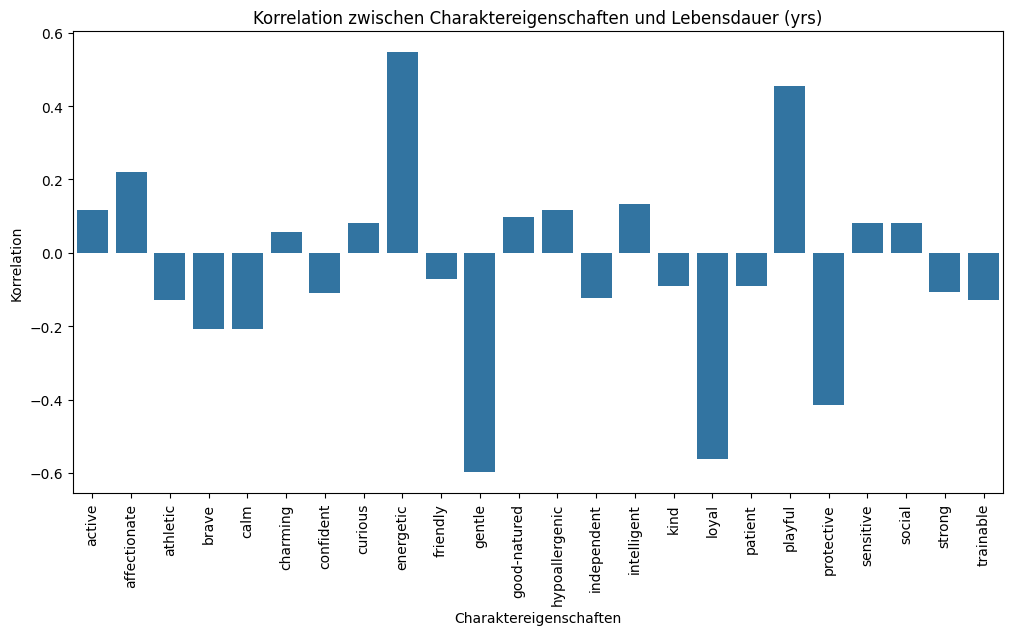

In [129]:
# Analyse der Korrelationen zwischen 'character_traits' und 'longevity_yrs'
correlation_character_longevity = character_traits_dummies.corrwith(df['longevity_yrs'])

plt.figure(figsize=(12, 6))
sns.barplot(x=correlation_character_longevity.index, y=correlation_character_longevity.values)
plt.xticks(rotation=90)
plt.title('Korrelation zwischen Charaktereigenschaften und Lebensdauer (yrs)')
plt.xlabel('Charaktereigenschaften')
plt.ylabel('Korrelation')

# Diagramm speichern
chart_path = f"../static/diagrams/correlation_between_character_and_longevity.png"
plt.savefig(chart_path)

plt.show()
plt.close()

<Figure size 1500x1000 with 0 Axes>

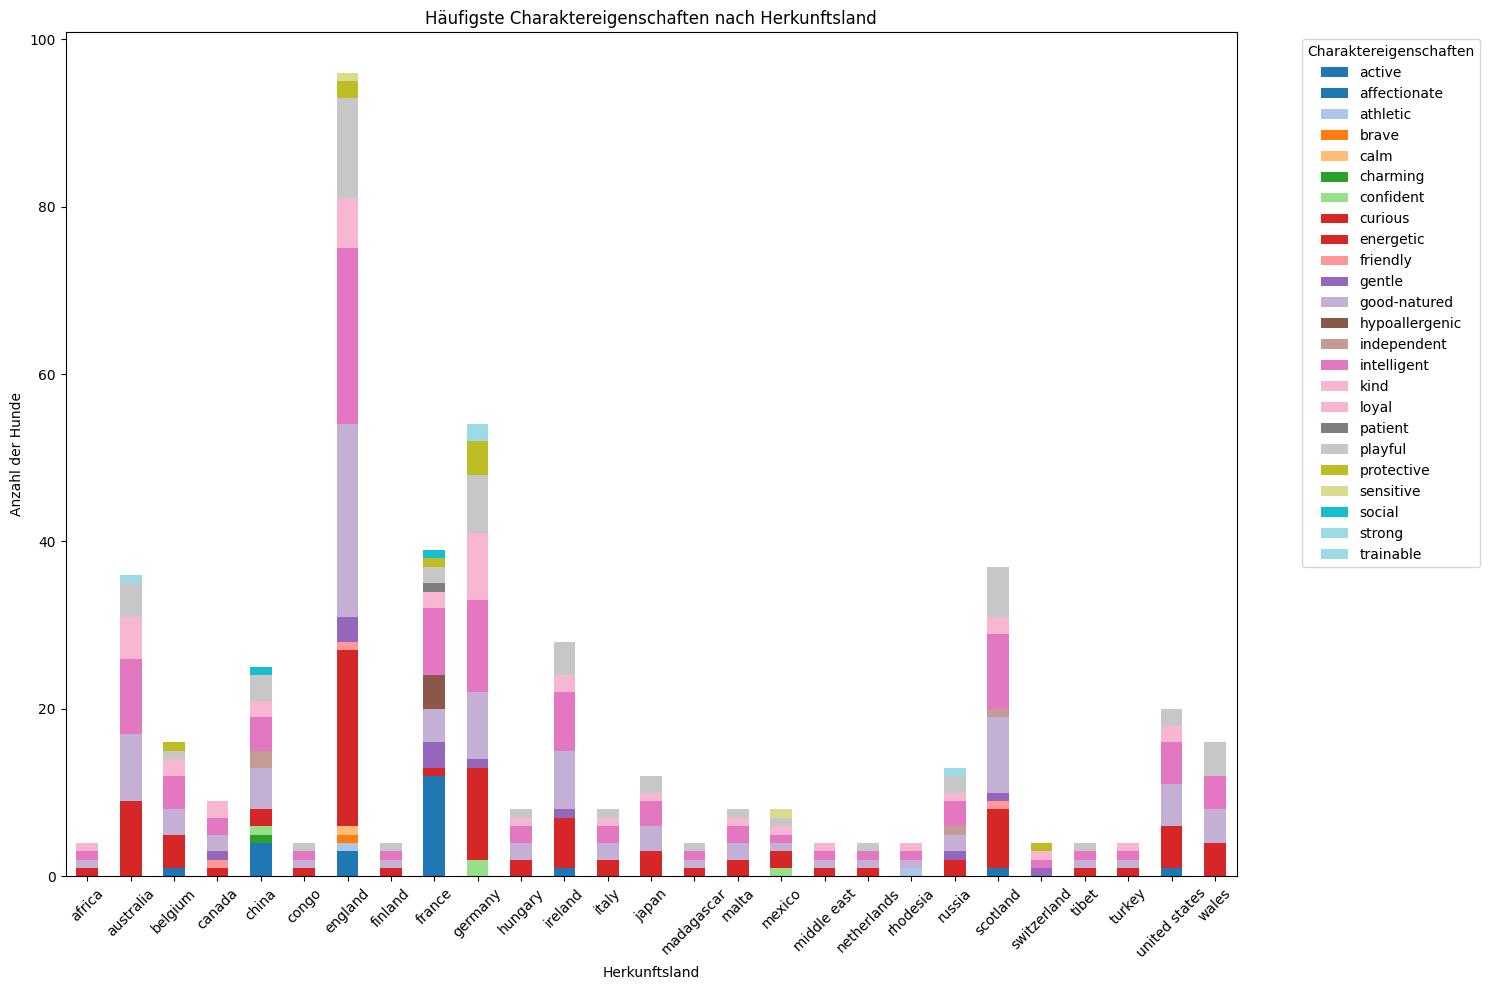

In [130]:
# Häufigste Charaktereigenschaften nach Herkunftsland
country_traits = pd.concat([df['country_of_origin'], character_traits_dummies], axis=1)
traits_by_country = country_traits.groupby('country_of_origin').sum()

plt.figure(figsize=(15, 10))
traits_by_country.plot(kind='bar', stacked=True, colormap='tab20', figsize=(15, 10))
plt.title('Häufigste Charaktereigenschaften nach Herkunftsland')
plt.xlabel('Herkunftsland')
plt.ylabel('Anzahl der Hunde')
plt.xticks(rotation=45)
plt.legend(title='Charaktereigenschaften', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Diagramm speichern
chart_path = f"../static/diagrams/traits_by_country.png"
plt.savefig(chart_path)

plt.show()
plt.close()

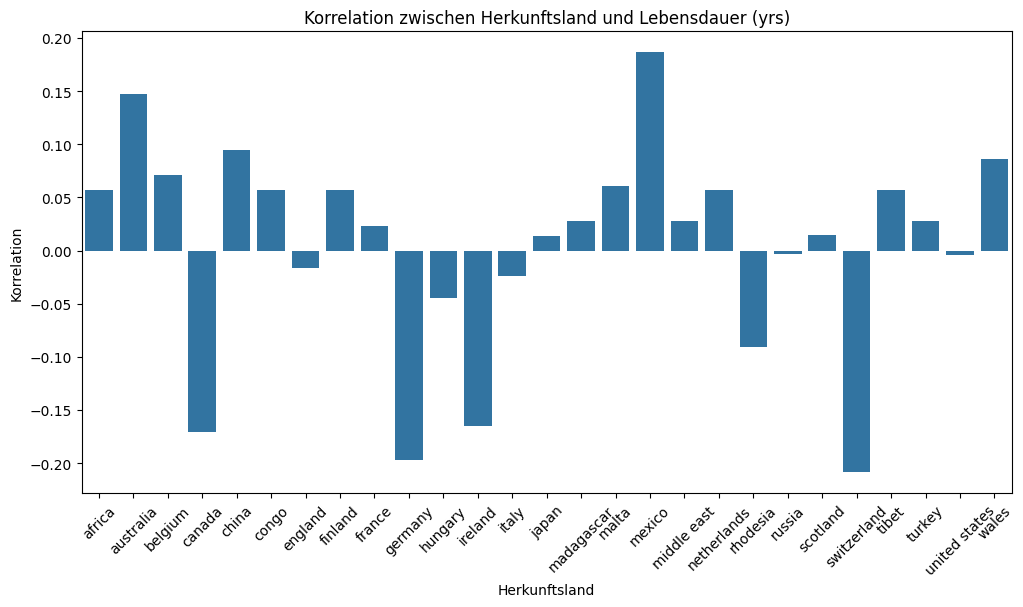

In [131]:
# Analyse der Korrelation zwischen 'country_of_origin' und 'longevity_yrs'
country_dummies = df['country_of_origin'].str.get_dummies()
correlation_country_longevity = country_dummies.corrwith(df['longevity_yrs'])

plt.figure(figsize=(12, 6))
sns.barplot(x=correlation_country_longevity.index, y=correlation_country_longevity.values)
plt.xticks(rotation=45)
plt.title('Korrelation zwischen Herkunftsland und Lebensdauer (yrs)')
plt.xlabel('Herkunftsland')
plt.ylabel('Korrelation')

# Diagramm speichern
chart_path = f"../static/diagrams/correlation_between_country_and_logevity.png"
plt.savefig(chart_path)

plt.show()
plt.close()

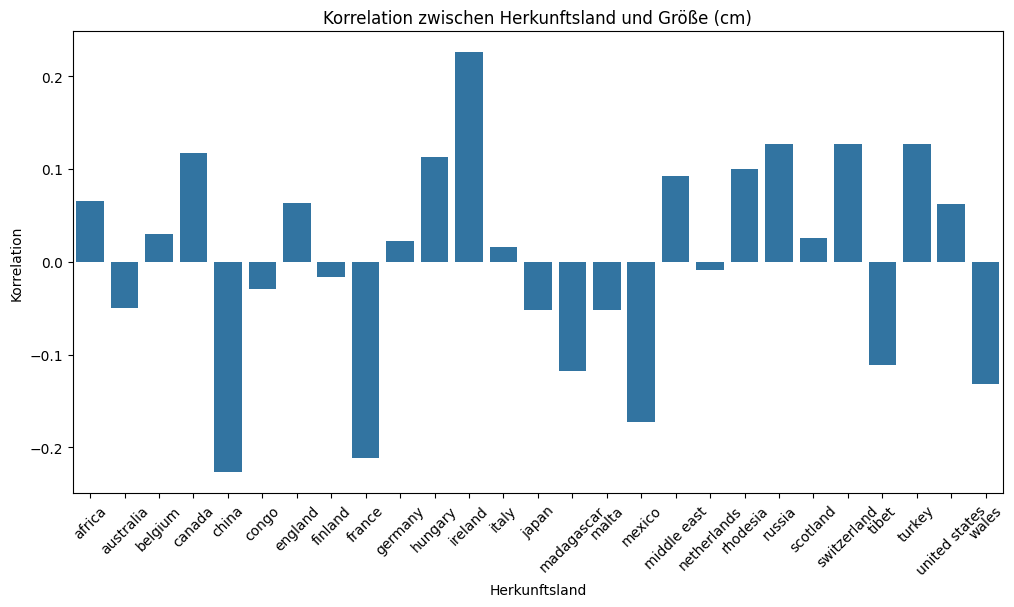

In [132]:
# Analyse der Korrelation zwischen 'country_of_origin' und 'height_cm'
correlation_country_height = country_dummies.corrwith(df['height_cm'])

plt.figure(figsize=(12, 6))
sns.barplot(x=correlation_country_height.index, y=correlation_country_height.values)
plt.xticks(rotation=45)
plt.title('Korrelation zwischen Herkunftsland und Größe (cm)')
plt.xlabel('Herkunftsland')
plt.ylabel('Korrelation')

# Diagramm speichern
chart_path = f"../static/diagrams/correlation_between_country_and_height.png"
plt.savefig(chart_path)

plt.show()
plt.close()

In [133]:
# Schließen der Datenbankverbindung
conn.close()